# Denoiser

Using a VAE to denoise reconstructed fragments.

In [3]:
%watermark -a "Lorenzo Cardarelli" -iv -v -m

Author: Lorenzo Cardarelli

Python implementation: CPython
Python version       : 3.9.16
IPython version      : 8.14.0

Compiler    : MSC v.1929 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 151 Stepping 2, GenuineIntel
CPU cores   : 20
Architecture: 64bit

cv2        : 4.8.0
seaborn    : 0.12.2
matplotlib : 3.7.1
PIL        : 9.5.0
skimage    : 0.21.0
numpy      : 1.24.3
pandas     : 2.0.2
torch      : 2.0.1+cu118
torchvision: 0.15.2+cu118
scipy      : 1.11.3



In [1]:
# standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.transform import rescale, resize, downscale_local_mean

# pytorch imports
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.utils import make_grid
import torch.nn.functional as F
import torch.optim as optim


# training and utils imports
from sklearn.model_selection import train_test_split
from torchinfo import summary
import cv2
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import r2_score
from tqdm import tqdm

from utils import *
from models import *
from dataset import *

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
define_reproducibility(42)

Reproducibility is set to 42.


### Prepare data

In [5]:
pots = load_pots('new_dataset.npz').reshape(-1, 256, 256)

In [6]:
tabular_data = pd.read_excel('selected_info_new_dataset.xlsx')

In [7]:
encoders = fit_and_transform_encoders(tabular_data, ["Functional_class", "Morphology"])
transformed_data = transform_data_using_encoders(tabular_data[["Functional_class","Morphology"]], encoders)

Define some hyperparameters.

In [8]:
BATCH_SIZE = 128
EPOCHS = 50
LEARNING_RATE = 0.001
IMG_SIZE = 128
LATENT_DIMS = 100

In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(IMG_SIZE, antialias=True),
    transforms.GaussianBlur(3),
    transforms.RandomRotation(5),
    transforms.RandomAffine(0, (0.01,0.01)) #0.01
    ])

Train and test plit.

In [10]:
test_size = 0.2

num_samples = len(tabular_data)
num_samples_test = int(test_size * num_samples)


indices = list(range(num_samples))
indices_train, indices_test = train_test_split(indices, test_size=test_size, random_state=42)


pots_train = pots[tabular_data.index][indices_train]
functional_encoded_train = transformed_data.values[indices_train]

pots_test = pots[tabular_data.index][indices_test]
functional_encoded_test = transformed_data.values[indices_test]

In [11]:
len(pots_train), len(pots_test)

(3090, 773)

In [12]:
pots_pytorch_trn = PotTorch(pots_train, functional_encoded_train, transform=transform, img_size=IMG_SIZE)
pots_pytorch_tst = PotTorch(pots_test, functional_encoded_test, transform=transform, img_size=IMG_SIZE)

In [13]:
data_loader_train = DataLoader(dataset = pots_pytorch_trn, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
data_loader_test = DataLoader(dataset = pots_pytorch_tst, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [14]:
pot, masked_img, padded_tensor, bounding_box, scale_factor, archeo_info, mask, blurred_tensor = next(iter(data_loader_train))

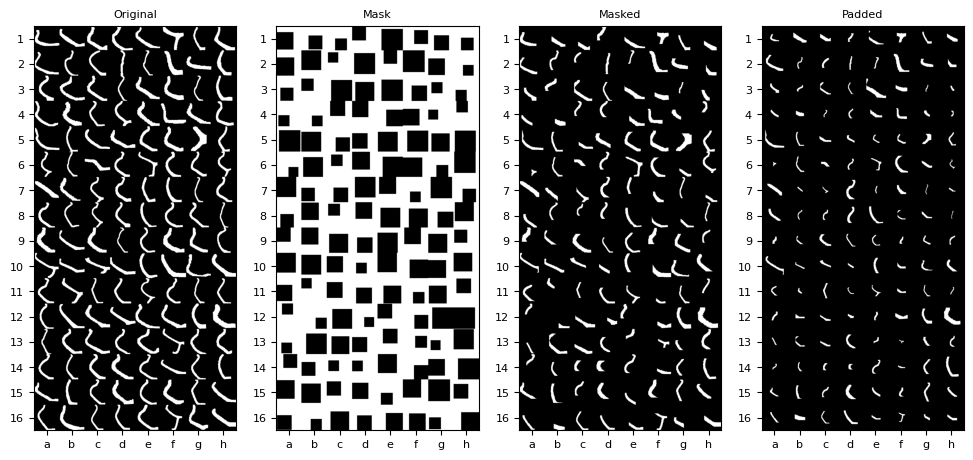

In [15]:
plot_batches([pot, mask, masked_img, padded_tensor], title_list=["Original", "Mask", "Masked", "Padded"], 
             figsize=(12, 8), nrow=8, title_size=8, tick_size=8)

In [16]:
dae = DenoisingAutoencoder(latent_dims=LATENT_DIMS).to(device)

optimizer = torch.optim.Adam(dae.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
custom_loss = CustomLossMSE(mask_weight=0.2)

In [17]:
### Create a list to store the losses over training
train_losses = []
test_losses = []
outputs_train = []
outputs_test = []


for epoch in tqdm(range(EPOCHS), desc="Training Progress"):
    ### Set the model to train mode
    dae.train()
    total_loss_train = 0
    for batch, (pot, masked, padded_tensor, bounding_box, scale_factor, archeo_info, mask, blurred_tensor) in enumerate(data_loader_train):
        
        ### Move the data to the device (GPU if available).
        pot = pot.to(device).float()
        blurred_tensor = blurred_tensor.to(device).float()
        

        ### Invert the mask
        inverted_mask = ~mask
        inverted_mask = inverted_mask.to(device).float()
        
        ### Forwards pass        
        decoded = dae(blurred_tensor)                                
                

        ### Calculate the pixelwise loss
        loss_total_train = custom_loss(pot, decoded, inverted_mask)


        ### Backpropagation
        optimizer.zero_grad()
        loss_total_train.backward()
        optimizer.step()

        ### Update the total loss   
        total_loss_train += loss_total_train.item()

    ### Calculate the average loss over the epoch
    average_loss = total_loss_train / len(data_loader_train)
    
    ### Append the average loss to the list of losses
    train_losses.append(average_loss)
    outputs_train.append((epoch, decoded, blurred_tensor, pot))

    ### Set the model to evaluation mode
    dae.eval()

    total_test_loss = 0


    with torch.no_grad():
        for batch_idx, (pot, masked, padded_tensor, bounding_box, scale_factor, archeo_info, mask, blurred_tensor) in enumerate(data_loader_test):
            
            ### Move the data to the device (GPU if available).
            pot = pot.to(device).float()
            blurred_tensor = blurred_tensor.to(device).float()
            

            ### Invert the mask
            inverted_mask = ~mask
            inverted_mask = inverted_mask.to(device).float()
            
            ### Forwards pass        
            decoded = dae(blurred_tensor)                                
                    

            ### Calculate the pixelwise loss
            loss_total_test = custom_loss(pot, decoded, inverted_mask)

            total_test_loss += loss_total_test.item()
        
        ### Calculate the average loss over the epoch
        average_loss_test = total_test_loss / len(data_loader_test)

        ### Append the average loss to the list of losses
        test_losses.append(average_loss_test)
        outputs_test.append((epoch, decoded, blurred_tensor, pot))

    if epoch % 5 == 0:
        tqdm.write(f'Epoch [{epoch + 1}/{EPOCHS}] - Training Loss: {average_loss:.4f} - Testing Loss: {average_loss_test:.4f}')

Training Progress:   2%|▏         | 1/50 [00:24<19:38, 24.06s/it]

Epoch [1/50] - Training Loss: 183281.3379 - Testing Loss: 123851.5417


Training Progress:  12%|█▏        | 6/50 [03:17<26:48, 36.55s/it]

Epoch [6/50] - Training Loss: 26239.3612 - Testing Loss: 24978.4980


Training Progress:  22%|██▏       | 11/50 [06:02<19:38, 30.23s/it]

Epoch [11/50] - Training Loss: 16257.1013 - Testing Loss: 15879.5462


Training Progress:  32%|███▏      | 16/50 [08:12<16:39, 29.39s/it]

Epoch [16/50] - Training Loss: 13626.9038 - Testing Loss: 13860.7682


Training Progress:  42%|████▏     | 21/50 [11:33<18:10, 37.59s/it]

Epoch [21/50] - Training Loss: 12208.2460 - Testing Loss: 12318.4072


Training Progress:  52%|█████▏    | 26/50 [14:01<11:08, 27.84s/it]

Epoch [26/50] - Training Loss: 11780.7094 - Testing Loss: 11483.9486


Training Progress:  62%|██████▏   | 31/50 [15:49<07:10, 22.67s/it]

Epoch [31/50] - Training Loss: 11289.9341 - Testing Loss: 11010.6240


Training Progress:  72%|███████▏  | 36/50 [17:37<05:03, 21.71s/it]

Epoch [36/50] - Training Loss: 10469.7636 - Testing Loss: 10541.0749


Training Progress:  82%|████████▏ | 41/50 [19:24<03:14, 21.62s/it]

Epoch [41/50] - Training Loss: 10175.7039 - Testing Loss: 10072.4674


Training Progress:  92%|█████████▏| 46/50 [21:13<01:26, 21.62s/it]

Epoch [46/50] - Training Loss: 10072.0245 - Testing Loss: 9878.1317


Training Progress: 100%|██████████| 50/50 [22:39<00:00, 27.19s/it]


In [18]:
train_losses_array_MSE = np.array(train_losses)
test_losses_array_MSE = np.array(test_losses)

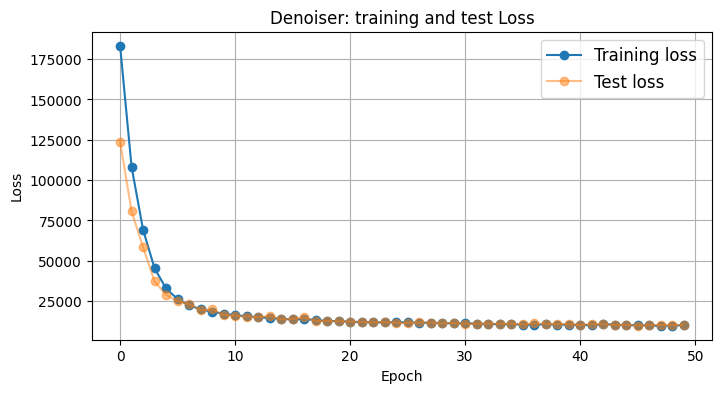

In [19]:
fig, ax = plt.subplots(figsize=(8, 4))

plt.plot(train_losses_array_MSE, label='Training loss', marker='o', linestyle='-')
plt.plot(test_losses_array_MSE, label='Test loss', marker='o', linestyle='-', alpha=0.5)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Denoiser: training and test Loss')

plt.legend(frameon=True, loc='upper right', fontsize='large')

# Display a grid for readability
plt.grid(True)

# Show the plot


plt.savefig('Denoiser_training_test_loss.png', dpi=300, bbox_inches='tight');

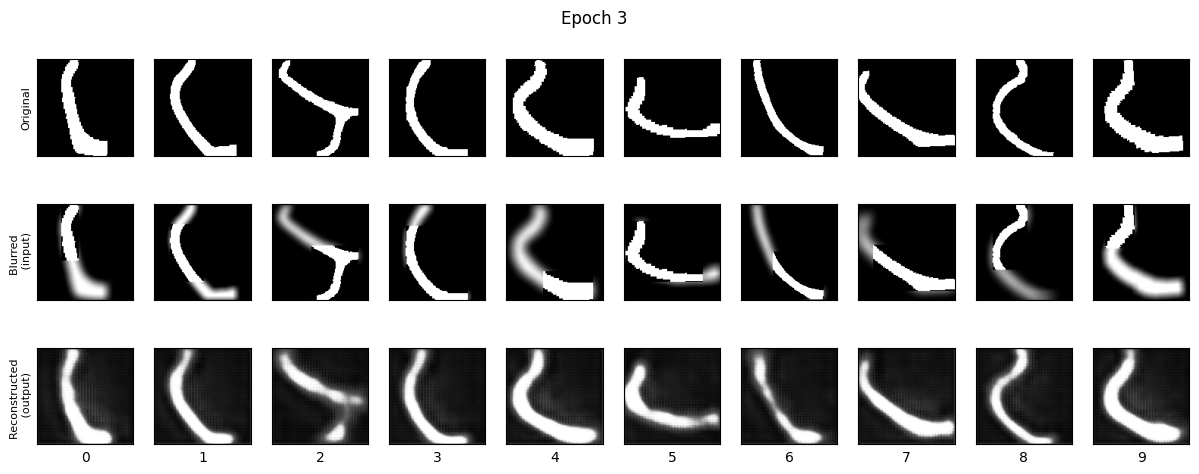

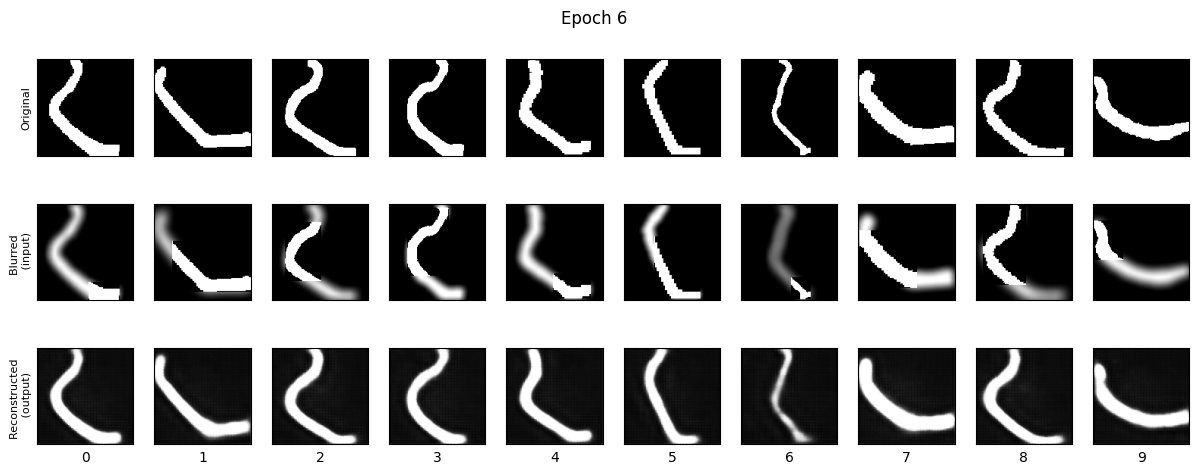

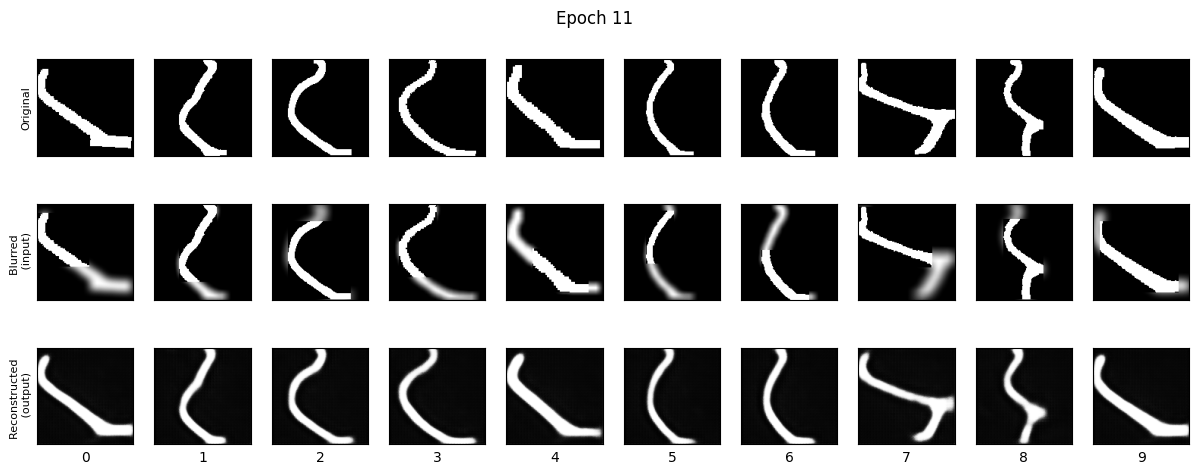

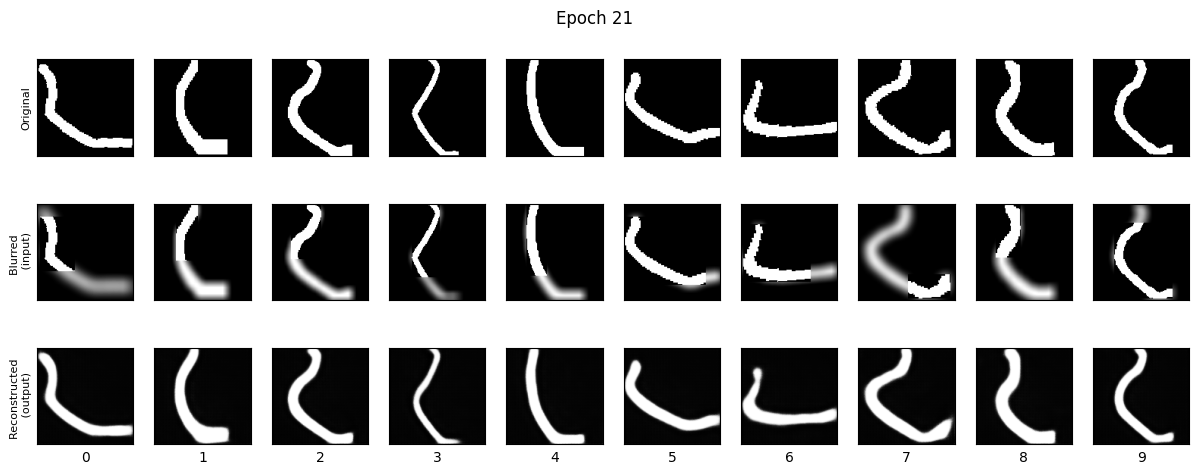

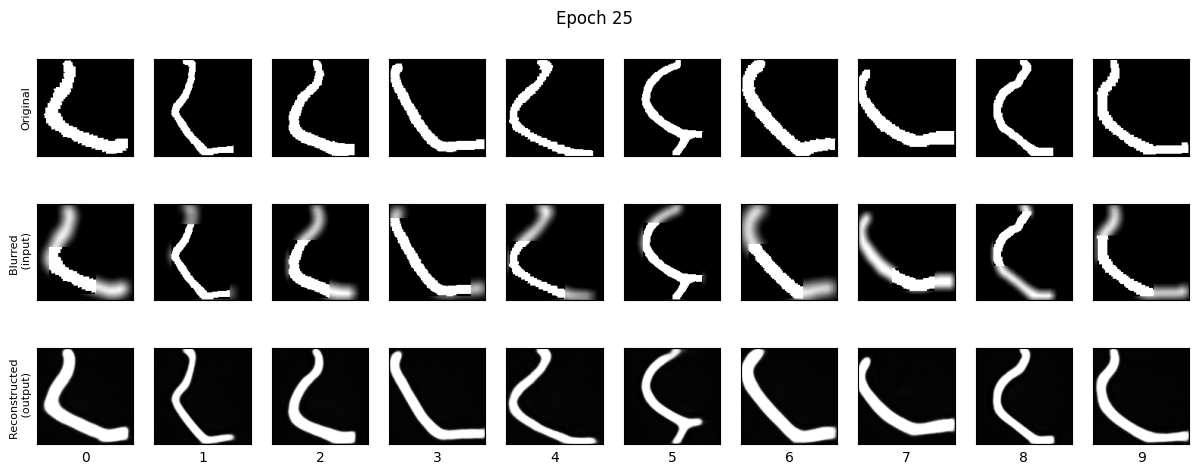

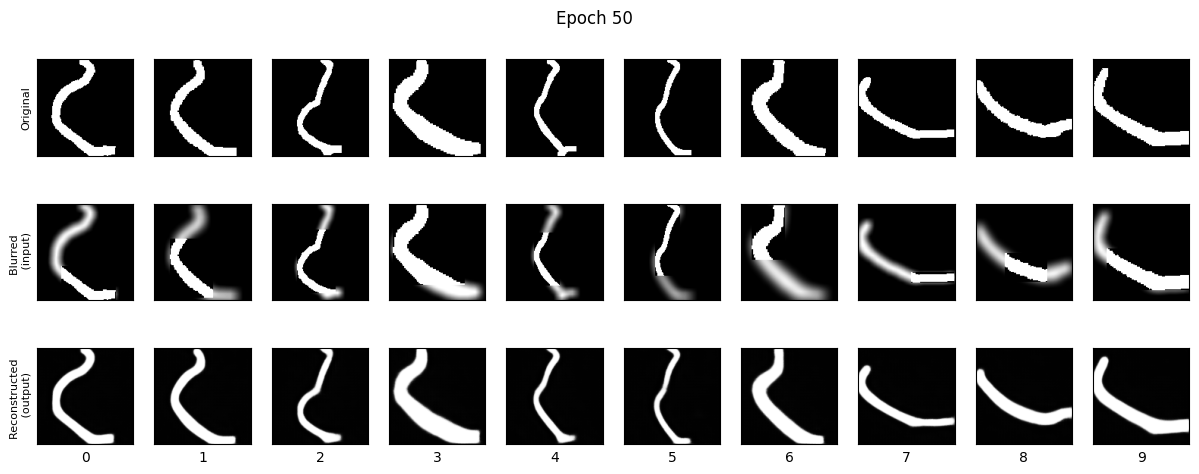

In [20]:
for k in [2,5,10, 20, 24, 49]:


    decoded_tensor = outputs_train[k][1].to("cpu").detach()
    masked_tensor = outputs_train[k][2].to("cpu").detach()
    pot_tensor = outputs_train[k][3].to("cpu").detach()


    row_mask = torch.all(torch.eq(masked_tensor, 0), dim=3, keepdim=True)
    col_mask = torch.all(torch.eq(masked_tensor, 0), dim=2, keepdim=True)
    x_filled = torch.where(row_mask, decoded_tensor, pot_tensor)
    decoded_filled = torch.where(col_mask, decoded_tensor, x_filled)

    decoded = decoded_tensor.numpy()
    masked = masked_tensor.numpy()
    pot = pot_tensor.numpy()
    decoded_filled = decoded_filled.numpy()

    plt_number = 10

    fig, ax = plt.subplots(3, int(plt_number), figsize=(15, 5),
    subplot_kw={'xticks':[], 'yticks':[]},
    gridspec_kw=dict(hspace=0.5, wspace=0.1))
    plt.suptitle(f"Epoch {k+1}")
    for i in range(int(plt_number)):
        ax[0, i].imshow(np.transpose(pot[i], (1,2,0)), cmap='binary_r')
        ax[1, i].imshow(np.transpose(masked[i],(1,2,0)), cmap='binary_r')
        ax[2, i].imshow(np.transpose(decoded[i],(1,2,0)), cmap='binary_r')
        ax[0, 0].set_ylabel('Original', fontsize=8)
        ax[1, 0].set_ylabel('Blurred \n (input)', fontsize=8)
        ax[2, 0].set_ylabel('Reconstructed \n (output)', fontsize=8)
        ax[2, i].set_xlabel(i)

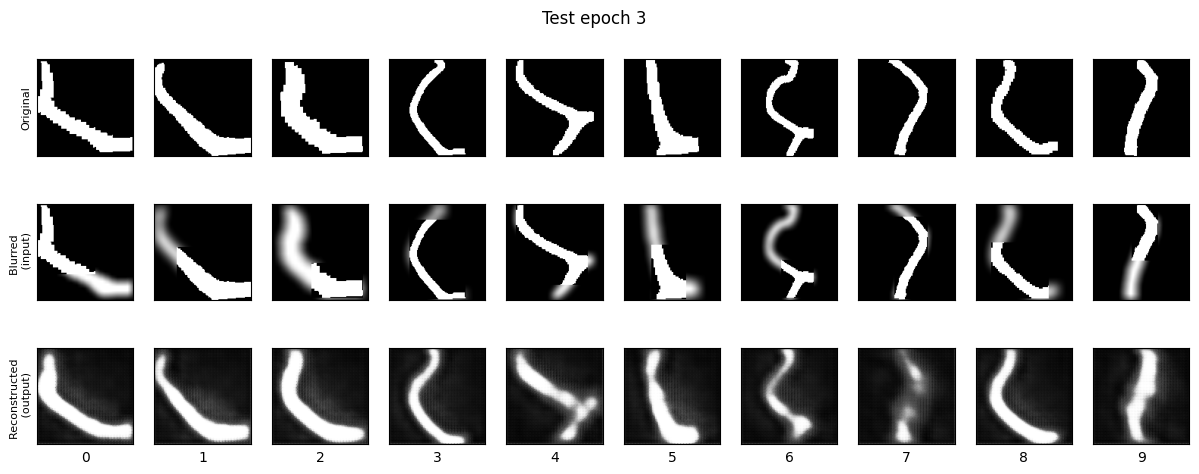

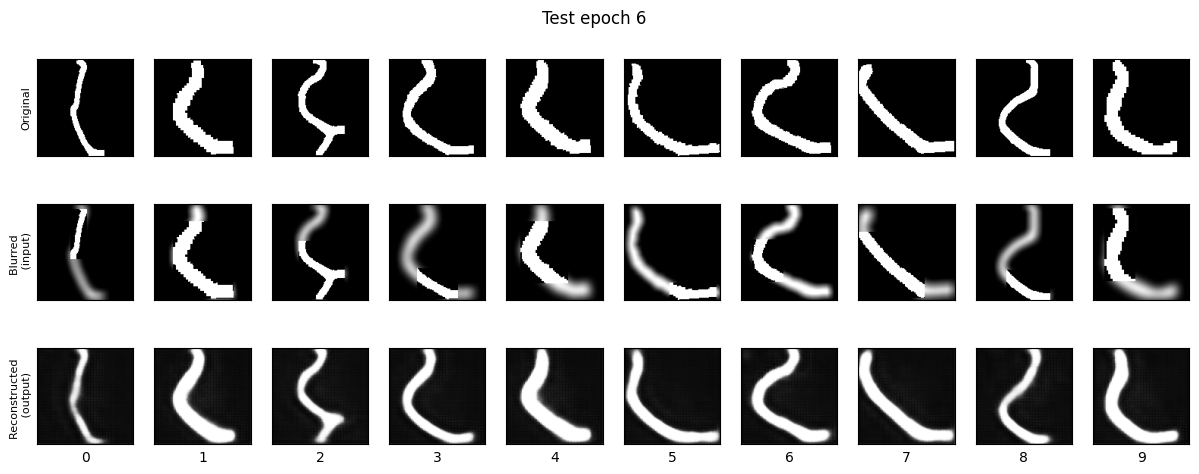

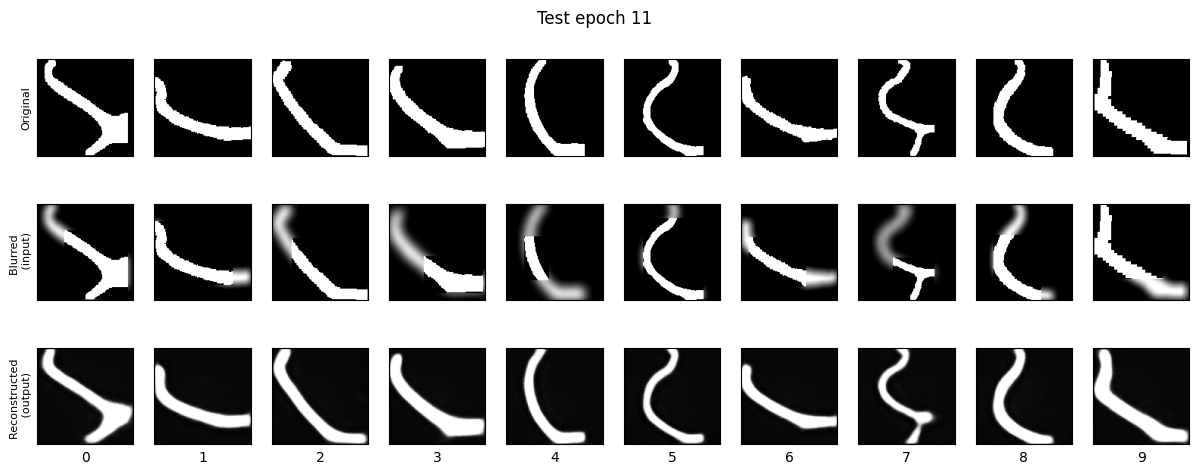

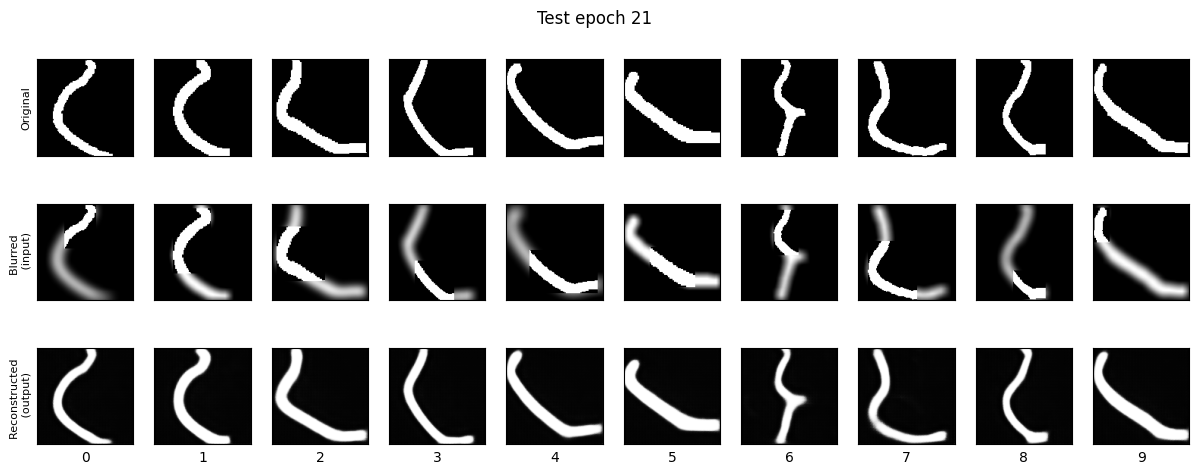

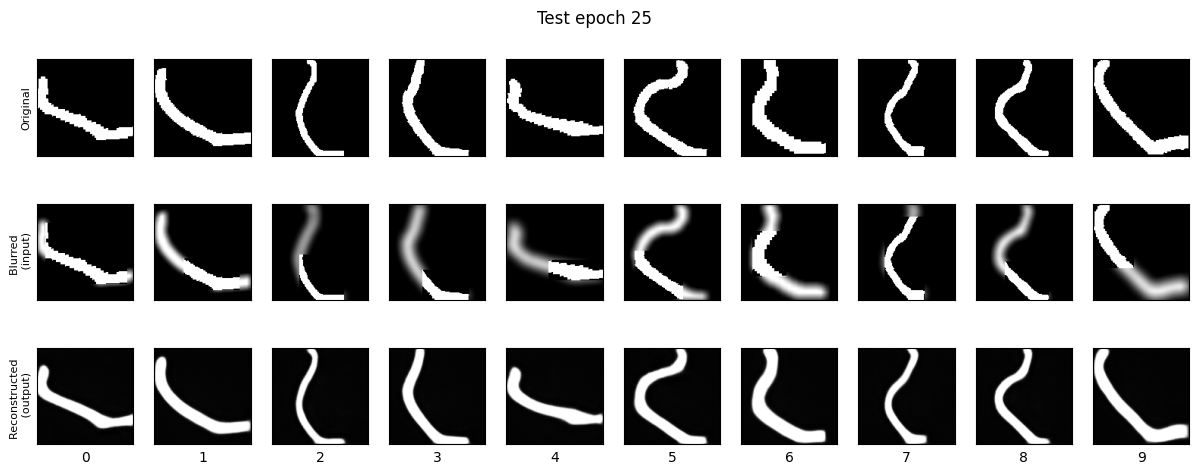

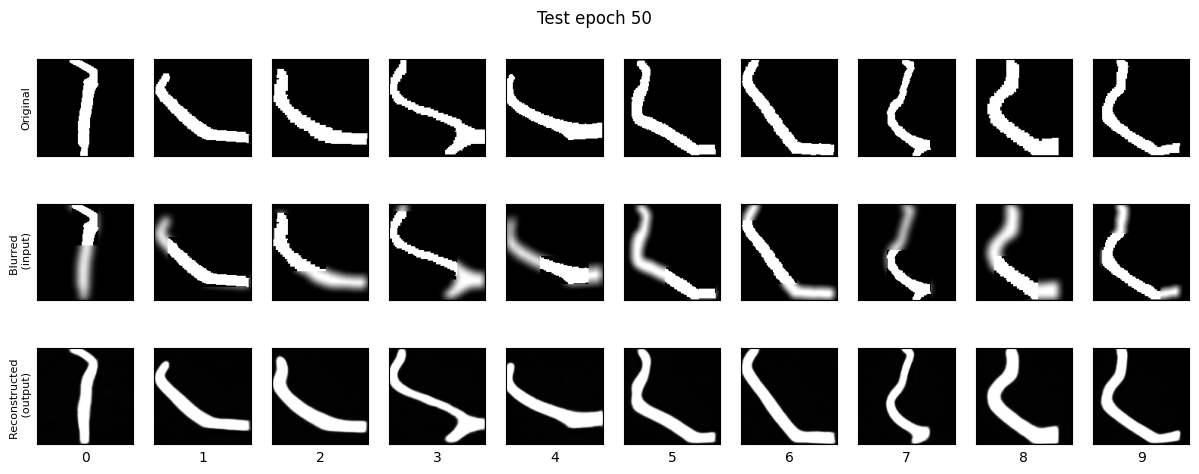

In [21]:
for k in [2,5,10, 20, 24, 49]:


    decoded_tensor = outputs_test[k][1].to("cpu").detach()
    masked_tensor = outputs_test[k][2].to("cpu").detach()
    pot_tensor = outputs_test[k][3].to("cpu").detach()


    row_mask = torch.all(torch.eq(masked_tensor, 0), dim=3, keepdim=True)
    col_mask = torch.all(torch.eq(masked_tensor, 0), dim=2, keepdim=True)
    x_filled = torch.where(row_mask, decoded_tensor, pot_tensor)
    decoded_filled = torch.where(col_mask, decoded_tensor, x_filled)

    decoded = decoded_tensor.numpy()
    masked = masked_tensor.numpy()
    pot = pot_tensor.numpy()
    decoded_filled = decoded_filled.numpy()

    plt_number = 10

    fig, ax = plt.subplots(3, int(plt_number), figsize=(15, 5),
    subplot_kw={'xticks':[], 'yticks':[]},
    gridspec_kw=dict(hspace=0.5, wspace=0.1))
    plt.suptitle(f"Test epoch {k+1}")
    for i in range(int(plt_number)):
        ax[0, i].imshow(np.transpose(pot[i], (1,2,0)), cmap='binary_r')
        ax[1, i].imshow(np.transpose(masked[i],(1,2,0)), cmap='binary_r')
        ax[2, i].imshow(np.transpose(decoded[i],(1,2,0)), cmap='binary_r')
        ax[0, 0].set_ylabel('Original', fontsize=8)
        ax[1, 0].set_ylabel('Blurred \n (input)', fontsize=8)
        ax[2, 0].set_ylabel('Reconstructed \n (output)', fontsize=8)
        ax[2, i].set_xlabel(i)

    if k == 49:
        plt.savefig('Denoiser_test_epoch_50.png', dpi=300, bbox_inches='tight');

In [22]:
torch.save(dae.state_dict(), "denoiser_model.pth")